Well and done


C:\Users\neele\AppData\Local\Temp\ipykernel_4412\1204256235.py:112: LangGraphDeprecatedSinceV10: ToolNode has been moved to langchain.agents.tool_node. Please update your import to 'from langchain.agents.tool_node import ToolNode'. Deprecated in LangGraph V1.0 to be removed in V2.0.
  tool_node = ToolNode(tools=[tavily_search])


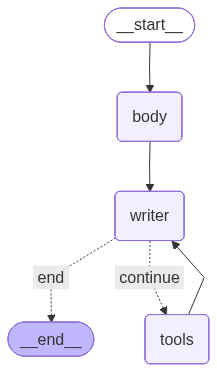

In [9]:
# %%
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
import gradio as gr
from langchain.tools import tool
from langchain_tavily import TavilySearch

# %%
load_dotenv(override=True)

# %%
api_key=os.getenv("OPENAI_API_KEY")
tavily="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"
#search_key=os.getenv("SEARCH_KEY")
if(api_key):
    print("Well and done")

# %%
#loading Model
llm=ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=api_key
)

# %%
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

# %%
def body(old_state: State) -> State:
    system_message = """You are a helpful blog-writing assistant.

    1️ First, if the user has not provided a topic yet — ask them what topic they want their blog on. The user will also specify the length of the blog.
    2️ When both topic and length are clear, pass the topic and length to writer agent.

    Always be conversational and clear.Do not write the blog yourself. The writer will do that by using the tool provided.
    """

    # --- Handle message accumulation safely ---
    if isinstance(old_state, dict):
        messages = old_state.get("messages", [])
    else:
        messages = old_state.messages

    # Prepend the system instruction
    messages = [{"role": "system", "content": system_message}] + messages

    # --- Invoke LLM ---
    response = llm.invoke(messages)

    # --- Return updated state ---
    new_messages = messages + [{"role": "assistant", "content": response.content}]
    return State(messages=new_messages)

@tool
def tavily_search(query: str):
  """Tool for web search"""
  search = TavilySearch(
    max_results=5,
    topic="general",
    tavily_api_key=tavily
    )
  return search.invoke(query)


llm_with_tools = llm.bind_tools([tavily_search])

def writer(old_state:State)->State:
    system_message = """Your role is to generate the blog body based on the provided topic title, and desired length. 
    You have a tool for searching on the web about the topic. You must use the tool to get the latest info about the topic.
    Example workflow:
    1. User asks: "Write a blog about AI trends"
    2. You call: tavily_search(query="latest AI trends 2025")
    3. You receive: Search results with current information
    4. You write: Blog post using the fresh data
    Always use the tool BEFORE writing content.
    """
    if isinstance(old_state, dict):
        messages = old_state.get("messages", [])
    else:
        messages = old_state.messages

    messages = [{"role": "system", "content": system_message}] + messages
    response=llm_with_tools.invoke(messages)
    new_messages= messages + [response]

    return State(messages=new_messages)

def should_continue(state: State): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"

# %%
#graph builder nodes
graph_builder.add_node("body",body)
graph_builder.add_node("writer",writer)
tool_node = ToolNode(tools=[tavily_search])
graph_builder.add_node("tools", tool_node)

# %%
#edges
graph_builder.add_edge(START,"body")
graph_builder.add_edge("body", "writer")
graph_builder.add_edge("tools", "writer")
graph_builder.add_conditional_edges("writer", should_continue, {"continue": "tools", "end": END})

memory=MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
config = {"configurable": {"thread_id": "1"}}
async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat).launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [11]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="i want a small sized blog on mcp servers. also sign it with today's date at the end", additional_kwargs={}, response_metadata={}, id='a9da3ffd-0287-42dc-b97c-aeb31bd173ae'), SystemMessage(content='You are a helpful blog-writing assistant.\n\n    1️ First, if the user has not provided a topic yet — ask them what topic they want their blog on. The user will also specify the length of the blog.\n    2️ When both topic and length are clear, pass the topic and length to writer agent.\n\n    Always be conversational and clear.Do not write the blog yourself. The writer will do that by using the tool provided.\n    ', additional_kwargs={}, response_metadata={}, id='e69ba9b1-9d0a-405c-938f-ab3e8cc99cf5'), AIMessage(content='Great! Just to clarify, when you say "small-sized blog," how many words are you thinking of? This will help me pass the right information along.', additional_kwargs={}, response_metadata={}, id='c154ac54-d392-45d4-bcb4